<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Pro/AI_HW4_woodenML_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (pro): древесные алгоритмы**

### **Постановка задач**

### **Домашнее задание состоит из двух подзадач:**

**1. В  разделе 1 ваша задача:**
-  реализовать свое решающее дерево
- сравнить его со стандартной имплементацией из sklearn

Функции и классы дерева вы должны оформить в модуль `hw4_code_pro.py`.

**2. В разделе два ваша задача:** решить задачу бинарной классификации при помощи написанного Вами дерева, а также леса из sklearn, а после интерпретировать лучшие модели. Чуть точнее

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT, а также RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**
- Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.
- Неэффективная реализация кода может негативно отразиться на оценке.

### **Формат сдачи:**
Задания сдаются через  anytask. Посылка должна содержать:
* Ноутбук в формате ipynb
* Модуль hw4_code_pro.py


### **Баллы:**

Суммарно за задание можно получить 10 основных баллов и 1 бонусный балло.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 2 февраля 23:59

**Продуктивной и интересной вам работы!**


In [6]:
!pip install optuna
!pip install lime
!pip install shap
!pip install psycopg2-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 1.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=6d50a4d88072d836ec9f263824b7601f2190ad6fb39d4a4e3a2918003ce18bcb
  Stored in directory: /Users/inreleppik/Library/Caches/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.3/455.3 kB 3.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 10.1 MB/s eta 0:00:0000:010:01


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import psycopg2
import psycopg2.extras

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

import warnings
warnings.filterwarnings('ignore')

# **1. Решающие деревья своими руками (6 баллов)**

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

Всего за часть вы можете получить 6 основных баллов и 1 бонусный.

### **Задание 1. (1 балл)**

Реализуйте функцию find_best_split из модуля hw4_code_pro.py

In [13]:
# Заполните код в модуле
from hw4_code_pro import find_best_split

### **Задание 2. (0.25 балла)**

Загрузите таблицу [students.csv](https://github.com/AnastasiyaMax/MLDS_ml_course_fall21/blob/main/hw/hw5_trees/students.csv). Это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling).

В наборе данных:
- признаки объекта записаны в первых пяти столбцах;
- в последнем записана целевая переменная (класс: 0 или 1).

По этим данным, используя функцию из задания 1, постройте:
- пять кривых "порог — значение критерия Джини" для всех пяти признаков;
- scatter-графики "значение признака — класс" для всех пяти признаков;

In [15]:
data = pd.read_csv('students.csv')
data.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


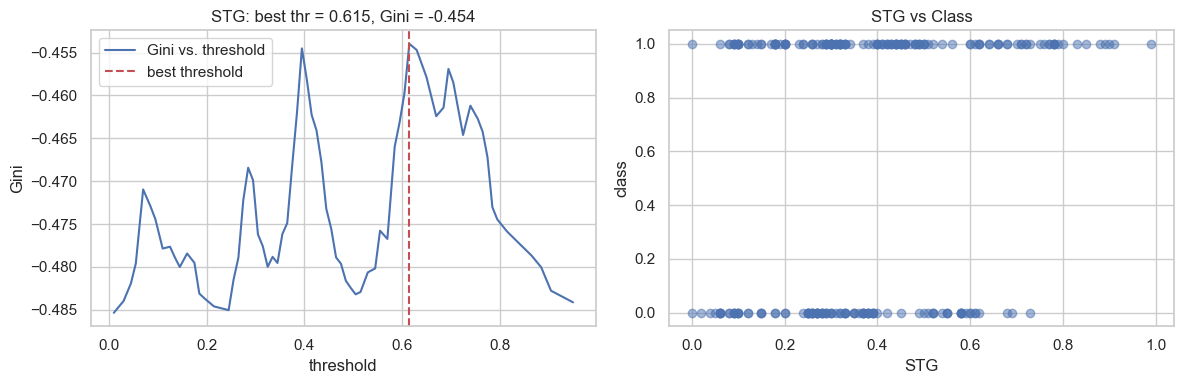

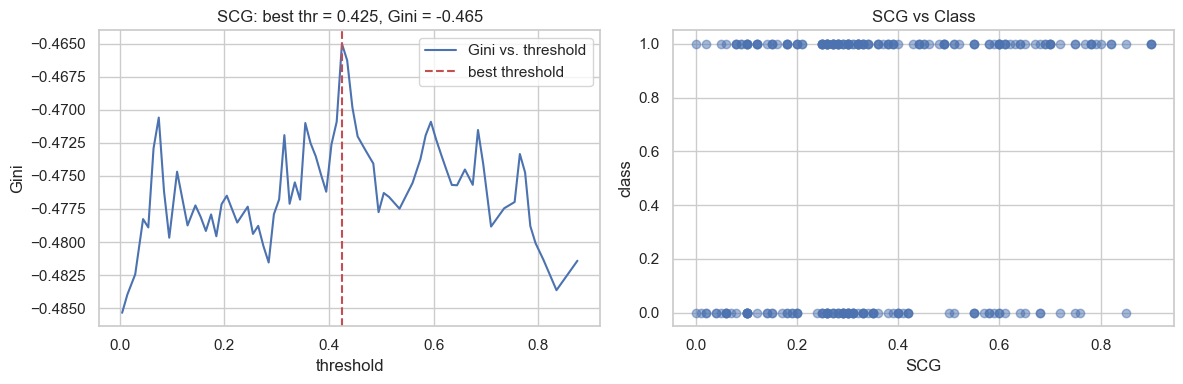

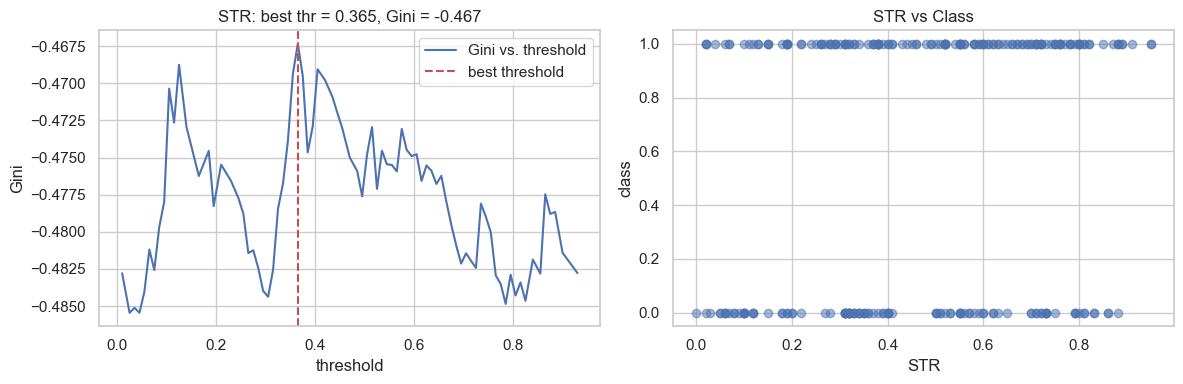

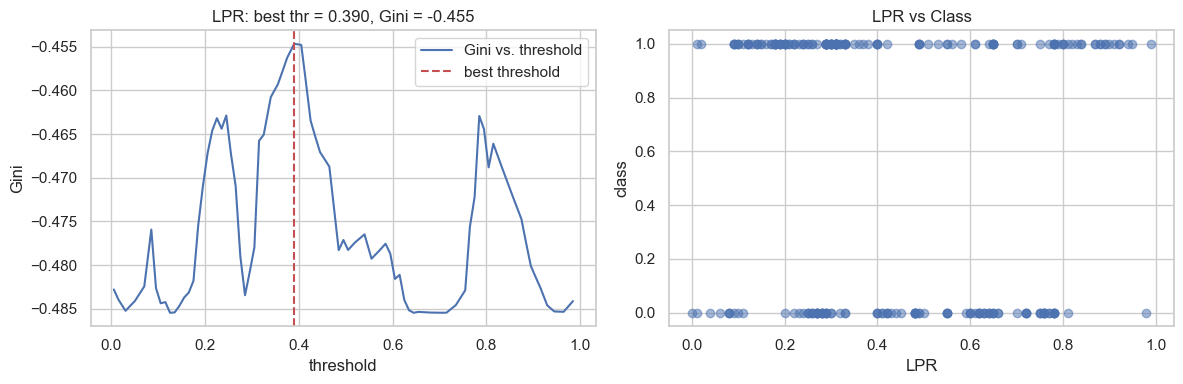

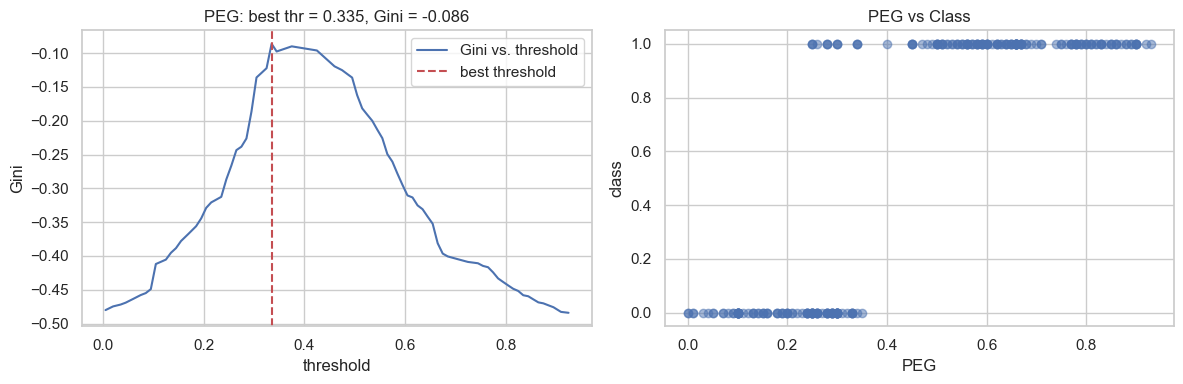

In [16]:
features = data.columns[:5] 
target = data.columns[-1]    

for feat_name in features:
    x = data[feat_name].values
    y = data[target].values
    
    thresholds, ginis, threshold_best, gini_best = find_best_split(x, y)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # График (порог -> Gini)
    ax1 = axes[0]
    ax1.plot(thresholds, ginis, label='Gini vs. threshold')
    if threshold_best is not None:
        ax1.axvline(threshold_best, color='r', linestyle='--', label='best threshold')
        ax1.set_title(f'{feat_name}: best thr = {threshold_best:.3f}, Gini = {gini_best:.3f}')
    else:
        ax1.set_title(f'{feat_name}: нет валидных порогов')
    ax1.set_xlabel('threshold')
    ax1.set_ylabel('Gini')
    ax1.legend()

    ax2 = axes[1]
    ax2.scatter(x, y, alpha=0.5)
    ax2.set_xlabel(feat_name)
    ax2.set_ylabel('class')
    ax2.set_title(f'{feat_name} vs Class')

    plt.tight_layout()
    plt.show()

### **Задание 3. (0.6 балла)**

Проанализируйтте построенные кривые. Ответьте на поставленные вопросы:
- По какому признаку нужно производить деление выборки на два поддерева? (0.15 балла)
- Согласуется ли этот результат с визуальной оценкой scatter-графиков? (0.15 балла)
- Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? (0.15 балла)
- Чем отличаются кривые для признаков, по которым деление практически невозможно? (0.15 балла)

**Ответ:**
1) Нужно производить деление по признаку `PEG`.
2) Да, на графике scatter-plot для данного признака видно относительно четкое разделение классов по сравнению с другими признаками.
3) Кривые для хороших признаков имеют ярко выраженный одиночный пик в области порога. При таком пороге классы чётко расходятся по разные стороны, и это видно как по самому максимуму, так и по резкому изменению Gini около этого порога.
4) На графиках threshold-Gini имеется несколько локальных пиков, а на графиках scatter-plot оба класса перемешаны и не имеют четкого разрыва.

### **Задание 4. (1.15 балла)**

В некоторых случаях необходимо анализировать код исполненного класса на предмет оптимальности и ошибок. Потренируйтесь в этом!

- Разберитесь с уже написанным кодом в классе DecisionTree модуля hw4_code_pro.py.
- Найдите ошибки в реализации метода \_fit_node.
- Напишите функцию \_predict_node.

**Примечание 1:**

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева».
- Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

**Примечание 2:**

- Выбор лучшего разбиения необходимо производить по критерию Джини.
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку, чтобы Джини упал
- Ответ в листе: наиболее часто встречающийся класс в листе.


### **Задание 5. (0.5 балла)**

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Для этого:

- Скачайте таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/))
- Прочитайте данные с помощью pandas
- Примените к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа.
- Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные)
- Сделайте предсказания для оставшейся половины.
- Вычислите accuracy (так как мы используем эту метрику и в силу задачи, нам не очень важно, что будет классом 1, а что — классом 0).  


У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from hw4_code_pro import DecisionTree
from sklearn.preprocessing import LabelEncoder

col_names = ['target','cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 
            'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
            'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type',
            'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

data1 = pd.read_csv("agaricus-lepiota.data", sep=",", skiprows=1, names = col_names)

data1_en = data1.copy()

for col in col_names:
    data1_en[col] = LabelEncoder().fit_transform(data1_en[col])


X = data1_en.iloc[:, 1:].values
y = data1_en.iloc[:, 0].values
clf = DecisionTree(feature_types=['categorical'] * X.shape[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(accuracy_score(y_test, preds))

1.0


### **Задание 6. (бонус, 1 балл)**

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующее задание).

In [26]:
col_names_1 = ['top-left-square', 'top-middle-square', 'top-right-square',
              'middle-left-square', 'middle-middle-square', 'middle-right-square',
              'bottom-left-square', 'bottom-middle-square', 'bottom-right-square', 'class']
data2 = pd.read_csv("tic-tac-toe.data", sep=',', skiprows=1, names = col_names_1)

for col in col_names_1:
    data2[col] = LabelEncoder().fit_transform(data2[col])

data2.head()

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,class
0,2,2,2,2,1,1,1,2,1,1
1,2,2,2,2,1,1,1,1,2,1
2,2,2,2,2,1,1,1,0,0,1
3,2,2,2,2,1,1,0,1,0,1
4,2,2,2,2,1,1,0,0,1,1


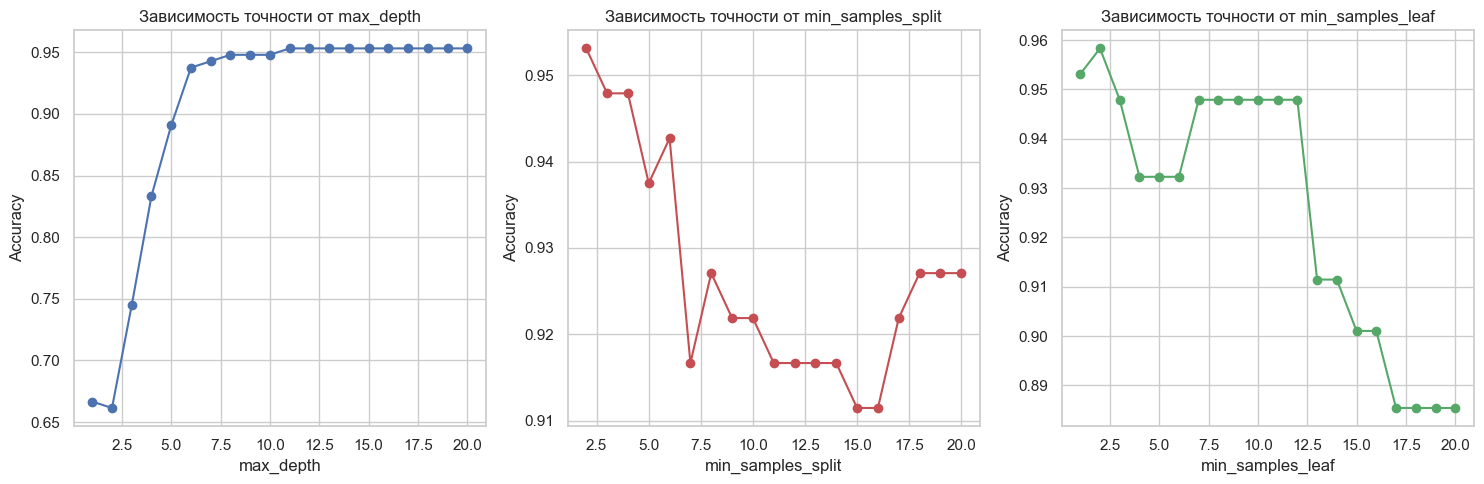

In [28]:
X = data2.iloc[:, :-1].values
y = data2.iloc[:, -1].values

max_depth_values = np.arange(1, 21)
min_samples_split_values = np.arange(2, 21)
min_samples_leaf_values = np.arange(1, 21)

# Списки для хранения точности
accuracy_max_depth = []
accuracy_min_samples_split = []
accuracy_min_samples_leaf = []

# Загружаем ваш датасет (замените X, y на ваш tic-tac-toe dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Исследуем влияние max_depth
for depth in max_depth_values:
    model = DecisionTree(feature_types=['categorical'] * X.shape[1], max_depth=depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_max_depth.append(accuracy_score(y_test, y_pred))

# Исследуем влияние min_samples_split
for min_split in min_samples_split_values:
    model = DecisionTree(feature_types=['categorical'] * X.shape[1], min_samples_split=min_split)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_min_samples_split.append(accuracy_score(y_test, y_pred))

# Исследуем влияние min_samples_leaf
for min_leaf in min_samples_leaf_values:
    model = DecisionTree(feature_types=['categorical'] * X.shape[1], min_samples_leaf=min_leaf)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_min_samples_leaf.append(accuracy_score(y_test, y_pred))

# Построение графиков
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(max_depth_values, accuracy_max_depth, marker='o')
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Зависимость точности от max_depth")

plt.subplot(1, 3, 2)
plt.plot(min_samples_split_values, accuracy_min_samples_split, marker='o', color='r')
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.title("Зависимость точности от min_samples_split")

plt.subplot(1, 3, 3)
plt.plot(min_samples_leaf_values, accuracy_min_samples_leaf, marker='o', color='g')
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.title("Зависимость точности от min_samples_leaf")

plt.tight_layout()
plt.show()


### **Задание 7. (2 балла)**

**1. Загрузите следующие наборы данных** (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (они записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

**2. Закодируйте категориальные признаки, использовав LabelEncoder.** С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

**Рекомендации:**
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами.

In [32]:
results = pd.DataFrame(columns=['DecisionTree_real', 'DecisionTree_categorical',
                               'DecisionTree_real_OHE', 'DecisionTreeClassifier'])
datasets_names = ['mushrooms', 'tic-tac-toe', 'cars', 'nursery']
exp_names = ['DecisionTree_real', 'DecisionTree_categorical',
             'DecisionTree_real_OHE', 'DecisionTreeClassifier']
for i in datasets_names:
    results.loc[i] = np.zeros(4)

**Данные**

In [34]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

col_names_1 = ['target','cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 
            'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
            'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type',
            'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

col_names_2 = ['top-left-square', 'top-middle-square', 'top-right-square',
              'middle-left-square', 'middle-middle-square', 'middle-right-square',
              'bottom-left-square', 'bottom-middle-square', 'bottom-right-square', 'class']

col_names_3 = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

col_names_4 = ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance',
              'social', 'health', 'class']


data1 = pd.read_csv("agaricus-lepiota.data", sep=",", skiprows=1, names = col_names_1)
data2 = pd.read_csv("tic-tac-toe.data", sep=',', skiprows=1, names = col_names_2)
data3 = pd.read_csv("car.data", sep=',', skiprows=1, names = col_names_3)
data3['class'] = data3['class'].apply(lambda x: 1 if x in ['good', 'vgood'] else 0)
data4 = pd.read_csv("nursery.data", sep=',', skiprows=1, names = col_names_4)
data4['class'] = data4['class'].apply(lambda x: 1 if x in ['very_recom', 'priority', 'spec_prior'] else 0)

In [35]:
# mushrooms
for col in col_names_1:
    data1[col] = LabelEncoder().fit_transform(data1[col])
    
data1.head()

,target,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [36]:
# tic-tac-toe
for col in col_names_2:
    data2[col] = LabelEncoder().fit_transform(data2[col])
    
data2.head()

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,class
0,2,2,2,2,1,1,1,2,1,1
1,2,2,2,2,1,1,1,1,2,1
2,2,2,2,2,1,1,1,0,0,1
3,2,2,2,2,1,1,0,1,0,1
4,2,2,2,2,1,1,0,0,1,1


In [37]:
# cars
for col in col_names_3:
    data3[col] = LabelEncoder().fit_transform(data3[col])

data3.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,0,0,2,2,0
1,3,3,0,0,2,0,0
2,3,3,0,0,1,1,0
3,3,3,0,0,1,2,0
4,3,3,0,0,1,0,0


In [38]:
# nursery
for col in col_names_4:
    data4[col] = LabelEncoder().fit_transform(data4[col])

data4.head()

,parents,has_nurs,form,children,housing,finance,social,health,class
0,2,3,0,0,0,0,0,1,1
1,2,3,0,0,0,0,0,0,0
2,2,3,0,0,0,0,2,2,0
3,2,3,0,0,0,0,2,1,1
4,2,3,0,0,0,0,2,0,0


**DecisionTree, считающий все признаки вещественными**

`mushrooms`

In [48]:
X = data1.iloc[:, 1:].values
y = data1.iloc[:, 0].values
cv = KFold(n_splits=10, shuffle=True)
clf = DecisionTree(feature_types=['real'] * X.shape[1])
scorer = make_scorer(accuracy_score)
scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(accuracy_score))

results.loc[datasets_names[0], exp_names[0]] = scores.mean()

print(f'Точность по фолдам: {scores}')
print(f'Средняя точность: {scores.mean()}')

Точность по фолдам: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Средняя точность: 1.0


`tic-tac-toe`

In [51]:
X = data2.iloc[:, :-1].values
y = data2.iloc[:, -1].values
cv = KFold(n_splits=10, shuffle=True)
clf = DecisionTree(feature_types=['real'] * X.shape[1])
scorer = make_scorer(accuracy_score)
scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(accuracy_score))

results.loc[datasets_names[1], exp_names[0]] = scores.mean()

print(f'Точность по фолдам: {scores}')
print(f'Средняя точность: {scores.mean()}')

Точность по фолдам: [0.89583333 0.8125     0.875      0.83333333 0.89583333 0.91666667
 0.85416667 0.83157895 0.81052632 0.92631579]
Средняя точность: 0.8651754385964912


`cars`

In [53]:
X = data3.iloc[:, :-1].values
y = data3.iloc[:, -1].values
cv = KFold(n_splits=10, shuffle=True)
clf = DecisionTree(feature_types=['real'] * X.shape[1])
scorer = make_scorer(accuracy_score)
scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(accuracy_score))

results.loc[datasets_names[2], exp_names[0]] = scores.mean()

print(f'Точность по фолдам: {scores}')
print(f'Средняя точность: {scores.mean()}')

Точность по фолдам: [1.         1.         0.98265896 0.98843931 0.98265896 0.98265896
 0.98265896 1.         0.99418605 0.99418605]
Средняя точность: 0.9907447237531926


`nursery`

In [57]:
X = data4.iloc[:, :-1].values
y = data4.iloc[:, -1].values
cv = KFold(n_splits=10, shuffle=True)
clf = DecisionTree(feature_types=['real'] * X.shape[1])
scorer = make_scorer(accuracy_score)
scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(accuracy_score))

results.loc[datasets_names[3], exp_names[0]] = scores.mean()

print(f'Точность по фолдам: {scores}')
print(f'Средняя точность: {scores.mean()}')

Точность по фолдам: [1.        1.        1.        0.9992284 1.        1.        0.9992284
 1.        1.        0.9992278]
Средняя точность: 0.9997684589351257


**DecisionTree, считающий все признаки категориальными**

`mushrooms`

In [61]:
X = data1.iloc[:, 1:].values
y = data1.iloc[:, 0].values
cv = KFold(n_splits=10, shuffle=True)
clf = DecisionTree(feature_types=['categorical'] * X.shape[1])
scorer = make_scorer(accuracy_score)
scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(accuracy_score))

results.loc[datasets_names[0], exp_names[1]] = scores.mean()

print(f'Точность по фолдам: {scores}')
print(f'Средняя точность: {scores.mean()}')

Точность по фолдам: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Средняя точность: 1.0


`tic-tac-toe`

In [63]:
X = data2.iloc[:, :-1].values
y = data2.iloc[:, -1].values
cv = KFold(n_splits=10, shuffle=True)
clf = DecisionTree(feature_types=['categorical'] * X.shape[1])
scorer = make_scorer(accuracy_score)
scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(accuracy_score))

results.loc[datasets_names[1], exp_names[1]] = scores.mean()

print(f'Точность по фолдам: {scores}')
print(f'Средняя точность: {scores.mean()}')

Точность по фолдам: [0.95833333 0.95833333 0.96875    0.92708333 0.97916667 0.97916667
 0.95833333 0.95789474 0.95789474 0.92631579]
Средняя точность: 0.9571271929824562


`cars`

In [65]:
X = data3.iloc[:, :-1].values
y = data3.iloc[:, -1].values
cv = KFold(n_splits=10, shuffle=True)
clf = DecisionTree(feature_types=['categorical'] * X.shape[1])
scorer = make_scorer(accuracy_score)
scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(accuracy_score))

results.loc[datasets_names[2], exp_names[1]] = scores.mean()

print(f'Точность по фолдам: {scores}')
print(f'Средняя точность: {scores.mean()}')

Точность по фолдам: [0.98265896 0.99421965 0.98843931 0.98843931 1.         1.
 0.98265896 0.98837209 0.99418605 0.99418605]
Средняя точность: 0.9913160371017609


`nursery`

In [67]:
X = data4.iloc[:, :-1].values
y = data4.iloc[:, -1].values
cv = KFold(n_splits=10, shuffle=True)
clf = DecisionTree(feature_types=['categorical'] * X.shape[1])
scorer = make_scorer(accuracy_score)
scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(accuracy_score))

results.loc[datasets_names[3], exp_names[1]] = scores.mean()

print(f'Точность по фолдам: {scores}')
print(f'Средняя точность: {scores.mean()}')

Точность по фолдам: [1.        1.        1.        1.        1.        1.        0.9992284
 0.9992284 0.9992284 0.9992278]
Средняя точность: 0.9996912984412984


**DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков**

`mushrooms`

In [71]:
X = pd.get_dummies(data1.iloc[:, 1:], columns= col_names_1[1:]).astype(int).values
y = data1.iloc[:, 0].values
cv = KFold(n_splits=10, shuffle=True)
clf = DecisionTree(feature_types=['real'] * X.shape[1])
scorer = make_scorer(accuracy_score)
scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(accuracy_score))

results.loc[datasets_names[0], exp_names[2]] = scores.mean()

print(f'Точность по фолдам: {scores}')
print(f'Средняя точность: {scores.mean()}')

Точность по фолдам: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Средняя точность: 1.0


`tic-tac-toe`

In [75]:
X = pd.get_dummies(data2.iloc[:, :-1], columns=col_names_2[:-1]).astype(int).values
y = data2.iloc[:, -1].values
cv = KFold(n_splits=10, shuffle=True)
clf = DecisionTree(feature_types=['real'] * X.shape[1])
scorer = make_scorer(accuracy_score)
scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(accuracy_score))

results.loc[datasets_names[1], exp_names[2]] = scores.mean()

print(f'Точность по фолдам: {scores}')
print(f'Средняя точность: {scores.mean()}')

Точность по фолдам: [0.94791667 0.92708333 0.95833333 0.96875    0.97916667 0.95833333
 0.95833333 0.95789474 0.95789474 0.93684211]
Средняя точность: 0.9550548245614037


`cars`

In [77]:
X = pd.get_dummies(data3.iloc[:, :-1], columns=col_names_3[:-1]).astype(int).values
y = data3.iloc[:, -1].values
cv = KFold(n_splits=10, shuffle=True)
clf = DecisionTree(feature_types=['real'] * X.shape[1])
scorer = make_scorer(accuracy_score)
scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(accuracy_score))

results.loc[datasets_names[2], exp_names[2]] = scores.mean()

print(f'Точность по фолдам: {scores}')
print(f'Средняя точность: {scores.mean()}')

Точность по фолдам: [0.97687861 0.98265896 0.99421965 0.98265896 0.99421965 1.
 0.96531792 0.99418605 0.98255814 0.98837209]
Средняя точность: 0.98610700362952


`nursery`

In [80]:
X = pd.get_dummies(data4.iloc[:, :-1], columns=col_names_4[:-1]).astype(int).values
y = data4.iloc[:, -1].values
cv = KFold(n_splits=10, shuffle=True)
clf = DecisionTree(feature_types=['real'] * X.shape[1])
scorer = make_scorer(accuracy_score)
scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(accuracy_score))

results.loc[datasets_names[3], exp_names[2]] = scores.mean()

print(f'Точность по фолдам: {scores}')
print(f'Средняя точность: {scores.mean()}')

Точность по фолдам: [1.        1.        1.        1.        0.9992284 0.9992284 1.
 0.9992284 1.        0.9992278]
Средняя точность: 0.9996912984412984


**DecisionTreeClassifier из sklearn**

In [82]:
from sklearn.tree import DecisionTreeClassifier

`mushrooms`

In [85]:
X = data1.iloc[:, 1:]
y = data1.iloc[:, 0]
cv = KFold(n_splits=10, shuffle=True)
clf = DecisionTreeClassifier()
scorer = make_scorer(accuracy_score)
scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(accuracy_score))

results.loc[datasets_names[0], exp_names[3]] = scores.mean()

print(f'Точность по фолдам: {scores}')
print(f'Средняя точность: {scores.mean()}')

Точность по фолдам: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Средняя точность: 1.0


`tic-tac-toe`

In [89]:
X = data2.iloc[:, :-1]
y = data2.iloc[:, -1]
cv = KFold(n_splits=10, shuffle=True)
clf = DecisionTreeClassifier()
scorer = make_scorer(accuracy_score)
scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(accuracy_score))

results.loc[datasets_names[1], exp_names[3]] = scores.mean()

print(f'Точность по фолдам: {scores}')
print(f'Средняя точность: {scores.mean()}')

Точность по фолдам: [0.84375    0.9375     0.89583333 0.82291667 0.86458333 0.88541667
 0.90625    0.86315789 0.84210526 0.8       ]
Средняя точность: 0.8661513157894737


`cars`

In [95]:
X = data3.iloc[:, :-1]
y = data3.iloc[:, -1]
cv = KFold(n_splits=10, shuffle=True)
clf = DecisionTreeClassifier()
scorer = make_scorer(accuracy_score)
scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(accuracy_score))

results.loc[datasets_names[2], exp_names[3]] = scores.mean()

print(f'Точность по фолдам: {scores}')
print(f'Средняя точность: {scores.mean()}')

Точность по фолдам: [0.99421965 0.98265896 0.99421965 1.         0.98265896 0.95375723
 0.98843931 1.         1.         1.        ]
Средняя точность: 0.9895953757225433


`nursery`

In [98]:
X = data4.iloc[:, :-1]
y = data4.iloc[:, -1]
cv = KFold(n_splits=10, shuffle=True)
clf = DecisionTreeClassifier()
scorer = make_scorer(accuracy_score)
scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(accuracy_score))

results.loc[datasets_names[3], exp_names[3]] = scores.mean()

print(f'Точность по фолдам: {scores}')
print(f'Средняя точность: {scores.mean()}')

Точность по фолдам: [1.        1.        1.        1.        0.9992284 1.        1.
 1.        0.9992284 0.9992278]
Средняя точность: 0.9997684589351257


In [100]:
results

,DecisionTree_real,DecisionTree_categorical,DecisionTree_real_OHE,DecisionTreeClassifier
mushrooms,1.000000,1.000000,1.000000,1.000000
tic-tac-toe,0.865175,0.957127,0.955055,0.866151
cars,0.990745,0.991316,0.986107,0.989595
nursery,0.999768,0.999691,0.999691,0.999768


### **Задание 8. (0.5 балла)**

Проанализируйте результаты эксперимента. Ответьте на вопросы:
- Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.
- Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
- Если случайность есть, то можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

1) Алгоритмы для разных наборов данных ранжируются по разному. Например для датасета `tic-tac-toe` наилучшим оказался алгоритм DecisionTree, который считатл все переменные категориальными, а для набора данных cars лучше всего себя показал алгоритм из `sklearn`. Вероятно ранжирование алгоритмов связанно с самой стркутурой данных, а также от возможности четкого разделения классов по переменным.
2) Признаки в разных данных отличаются по структуре и количеству уникальных значений. Смотря на итоговые средние метрики можно заметить, что они слабо различаются в зависимости от алгоритмов в разных датасетах. Однако при обучении модели на данных `tic-tac-toe` можно увидеть элемент случайности, так как метрики в зависимости от алгоритма довольно сильно разнятся.
3) Вероятно, на элемент случайности можно повлиять подбором гиперпараметров, применением ансамблей, применением других кодировок, нормализацией данных или использованием другого метода кросс-валидации.

# **2. Задача бинарной классификации реализованным деревом (4 балла)**

Всего за эту часть можно получить 4 балла.

В этом разделе вам необходимо решить задачу бинарной классификации самописным деревом и лесом из sklearn, а после интерпретировать лучшие модели. А именно:

- Извлечь данные из базы данных;
- Предобработать датасет;
- Обучить собственный класс DT и RF из `sklearn` в как базовом варианте (гиперпараметры по умолчанию), так и с подбором гиперпараметров;
- Интерпретировать алгоритмы при помощи LIME или SHAP.


### **Познакомимся с задачей: постановка**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

In [107]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-02-15 23:49:57--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Распознаётся storage.yandexcloud.net (storage.yandexcloud.net)… 213.180.193.243
Подключение к storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 3579 (3,5K) [application/x-x509-ca-cert]
Сохранение в: «/Users/inreleppik/.postgresql/root.crt»

/Users/inreleppik/. 100%[===================>]   3,50K  --.-KB/s    за 0s      

2025-02-15 23:49:58 (1,11 GB/s) - «/Users/inreleppik/.postgresql/root.crt» сохранён [3579/3579]



### **Задание 9. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

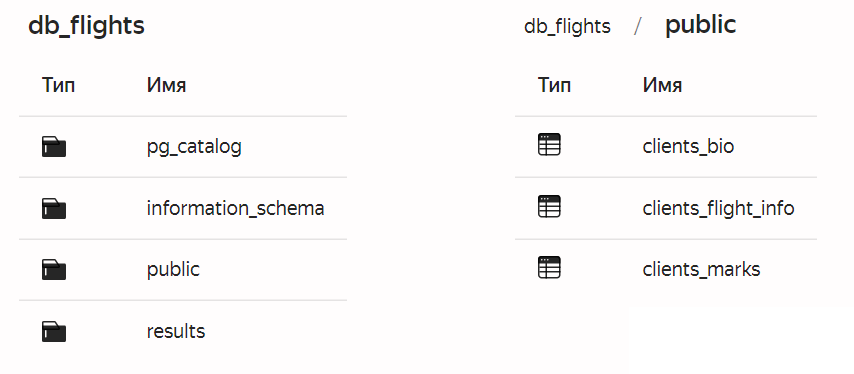

In [112]:
db_params = {
    "dbname": "db_flights",
    "user": "mlhs_student",
    "password": "mlhs_student",
    "host": "rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    "port": "6432",
    "sslmode": "verify-full"
}

try:
    # Устанавливаем соединение
    with psycopg2.connect(**db_params) as conn:
        with conn.cursor() as cur:
            # Проверяем подключение
            cur.execute("SELECT version();")
            db_version = cur.fetchone()
            print("Версия PostgreSQL:", db_version)

            # Получаем список таблиц в схеме public
            cur.execute("""
                SELECT tablename 
                FROM pg_catalog.pg_tables 
                WHERE schemaname = 'public';
            """)
            tables = cur.fetchall()
            print("Список таблиц в public:", [t[0] for t in tables])

except psycopg2.Error as e:
    print("Ошибка подключения:", e)

Версия PostgreSQL: ('PostgreSQL 14.12 (Ubuntu 14.12-201-yandex.53249.ae65d30249) on x86_64-pc-linux-gnu, compiled by gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0, 64-bit',)
Список таблиц в public: ['student_predictions', 'results.student_predictions', 'clients_marks', 'clients_flight_info', 'clients_bio']


In [114]:
try:
    with psycopg2.connect(**db_params) as conn:
        with conn.cursor() as cur:
            # SQL-запрос для получения информации о колонках
            cur.execute("""
                SELECT table_name, column_name, data_type 
                FROM information_schema.columns 
                WHERE table_schema = 'public' 
                AND table_name IN ('clients_bio', 'clients_flight_info', 'clients_marks');
            """)
            columns_info = cur.fetchall()
            print('Информация о колонках в таблицах:')
            for table, column, dtype in columns_info:
                print(f"Таблица: {table} | Колонка: {column} | Тип данных: {dtype}")

except psycopg2.Error as e:
    print('Ошибка подключения:', e)

Информация о колонках в таблицах:
Таблица: clients_bio | Колонка: id | Тип данных: integer
Таблица: clients_bio | Колонка: gender | Тип данных: text
Таблица: clients_bio | Колонка: age | Тип данных: text
Таблица: clients_flight_info | Колонка: id | Тип данных: integer
Таблица: clients_flight_info | Колонка: Customer Type | Тип данных: text
Таблица: clients_flight_info | Колонка: Type of Travel | Тип данных: text
Таблица: clients_flight_info | Колонка: class | Тип данных: text
Таблица: clients_flight_info | Колонка: Flight Distance | Тип данных: text
Таблица: clients_flight_info | Колонка: Departure Delay in Minutes | Тип данных: text
Таблица: clients_flight_info | Колонка: Arrival Delay in Minutes | Тип данных: text
Таблица: clients_marks | Колонка: id | Тип данных: integer
Таблица: clients_marks | Колонка: Inflight wifi service | Тип данных: text
Таблица: clients_marks | Колонка: Departure/Arrival time convenient | Тип данных: text
Таблица: clients_marks | Колонка: Ease of Online book

In [116]:
try:
    with psycopg2.connect(**db_params) as conn:
        with conn.cursor() as cur:
            cur.execute("""
                SELECT t1.*, t2.*, t3.*
                FROM public.clients_bio AS t1
                INNER JOIN public.clients_flight_info AS t2
                ON t1.id = t2.id
                LEFT JOIN public.clients_marks AS t3
                ON t2.id = t3.id;
            """)

            data = cur.fetchall()
            colnames = [desc[0] for desc in cur.description]

            df = pd.DataFrame(data, columns=colnames)

except psycopg2.Error as e:
    print('Ошибка подключения:', e)

In [118]:
df.head()

,id,gender,age,id,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
0,7,Male,43.0,7,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,...,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
1,13,Male,24.0,13,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,...,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
2,18,Female,61.0,18,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,...,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
3,31,Male,35.0,31,disloyal Customer,Business travel,Business,212.0,0.0,0.0,...,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
4,39,Female,46.0,39,Loyal Customer,Business travel,Business,67.0,0.0,0.0,...,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied


In [120]:
df = df.loc[:, ~df.columns.duplicated()]

In [122]:
df.replace('nan', np.nan, inplace=True)

In [123]:
df.set_index('id', inplace=True)

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129549 non-null  object
 1   age                                129234 non-null  object
 2   Customer Type                      129472 non-null  object
 3   Type of Travel                     129448 non-null  object
 4   class                              129433 non-null  object
 5   Flight Distance                    129455 non-null  object
 6   Departure Delay in Minutes         129442 non-null  object
 7   Arrival Delay in Minutes           129042 non-null  object
 8   Inflight wifi service              129505 non-null  object
 9   Departure/Arrival time convenient  129500 non-null  object
 10  Ease of Online booking             129506 non-null  object
 11  Gate location                      129512 non-null  objec

In [128]:
float_cols = iter(['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Inflight wifi service',
             'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 
             'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service',
             'Baggage handling', 'Checkin service', 'Inflight service', 'cleanliness'])

for col in float_cols:
    df[col] = df[col].astype(float)

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float64
 2   Customer Type                      129472 non-null  object 
 3   Type of Travel                     129448 non-null  object 
 4   class                              129433 non-null  object 
 5   Flight Distance                    129455 non-null  float64
 6   Departure Delay in Minutes         129442 non-null  float64
 7   Arrival Delay in Minutes           129042 non-null  float64
 8   Inflight wifi service              129505 non-null  float64
 9   Departure/Arrival time convenient  129500 non-null  float64
 10  Ease of Online booking             129506 non-null  float64
 11  Gate location                      129512 no

In [132]:
assert df.shape == (129_549, 23)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [135]:
df_train = df[df.satisfaction != '-']

df_train.head()

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
7,Male,43.0,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,3.0,3.0,...,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,satisfied
13,Male,24.0,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,2.0,2.0,...,2.0,5.0,5.0,2.0,4.0,4.0,2.0,4.0,5.0,neutral or dissatisfied
18,Female,61.0,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,2.0,5.0,...,1.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,1.0,neutral or dissatisfied
31,Male,35.0,disloyal Customer,Business travel,Business,212.0,0.0,0.0,2.0,2.0,...,2.0,2.0,2.0,4.0,5.0,5.0,5.0,4.0,2.0,neutral or dissatisfied
39,Female,46.0,Loyal Customer,Business travel,Business,67.0,0.0,0.0,3.0,3.0,...,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,satisfied


In [137]:
assert df_train.shape == (103_644, 23)

In [139]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test.head()

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
id,,,,,,,,,,,,,,,,,,,,,
55,Male,36.0,Loyal Customer,Business travel,Business,3655.0,40.0,71.0,1.0,1.0,...,1.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0,3.0,2.0
79,Female,70.0,Loyal Customer,Personal Travel,Eco,108.0,50.0,41.0,5.0,4.0,...,4.0,4.0,4.0,3.0,3.0,0.0,3.0,5.0,3.0,5.0
126,Male,66.0,Loyal Customer,Personal Travel,Eco,562.0,88.0,84.0,2.0,5.0,...,5.0,2.0,5.0,5.0,3.0,5.0,2.0,5.0,5.0,5.0
199,Female,60.0,Loyal Customer,Business travel,Business,3756.0,36.0,24.0,4.0,4.0,...,2.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0
263,Male,43.0,Loyal Customer,Personal Travel,Business,802.0,0.0,0.0,1.0,2.0,...,2.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0


In [141]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид.

In [144]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [146]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129549 entries, 7 to 129876
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float64
 2   Customer Type                      129472 non-null  object 
 3   Type of Travel                     129448 non-null  object 
 4   class                              129433 non-null  object 
 5   Flight Distance                    129455 non-null  float64
 6   Departure Delay in Minutes         129442 non-null  float64
 7   Arrival Delay in Minutes           129042 non-null  float64
 8   Inflight wifi service              129505 non-null  float64
 9   Departure/Arrival time convenient  129500 non-null  float64
 10  Ease of Online booking             129506 non-null  float64
 11  Gate location                      129512 no

### **Задание 10 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)
- Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.
- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

**Столбцы со значениями N/A в данных**

In [152]:
X_train.isna().sum()[df_train.isna().sum() > 0]

age                                  185
Customer Type                         52
Type of Travel                        70
class                                 66
Flight Distance                       54
Departure Delay in Minutes            61
Arrival Delay in Minutes             294
Inflight wifi service                 23
Departure/Arrival time convenient     28
Ease of Online booking                24
Gate location                         19
Food and drink                        22
Online boarding                       23
Seat comfort                          23
Inflight entertainment                30
On-board service                      23
Leg room service                      22
Baggage handling                      21
Checkin service                       22
Inflight service                      30
cleanliness                           21
dtype: int64

In [154]:
X_val.isna().sum()[df_test.isna().sum() > 0]

age                                   76
Customer Type                         14
Type of Travel                        18
class                                 23
Flight Distance                       18
Departure Delay in Minutes            23
Arrival Delay in Minutes             111
Inflight wifi service                  9
Departure/Arrival time convenient     13
Ease of Online booking                 9
Gate location                         11
Food and drink                        13
Online boarding                       14
Seat comfort                          18
Inflight entertainment                12
On-board service                       9
Leg room service                      14
Baggage handling                      11
Checkin service                       12
Inflight service                      19
cleanliness                           10
dtype: int64

In [156]:
df_test.isna().sum()[df_test.isna().sum() > 0]

age                                   54
Customer Type                         11
Type of Travel                        13
class                                 27
Flight Distance                       22
Departure Delay in Minutes            23
Arrival Delay in Minutes             102
Inflight wifi service                 12
Departure/Arrival time convenient      8
Ease of Online booking                10
Gate location                          7
Food and drink                        15
Online boarding                        9
Seat comfort                           6
Inflight entertainment                 3
On-board service                      12
Leg room service                      10
Baggage handling                      16
Checkin service                        8
Inflight service                      14
cleanliness                            6
dtype: int64

**Описательные статистики по числовым переменным**

In [159]:
X_train[X_train.columns[:13]].describe(include = 'number')

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink
count,72365.000000,72496.000000,72489.000000,72256.000000,72527.000000,72522.000000,72526.000000,72531.000000,72528.000000
mean,40.101665,1329.757256,15.872712,16.713699,2.733603,3.064656,2.760927,2.982683,3.209078
std,20.684510,4766.066508,70.890252,98.183683,1.362380,1.552445,1.415070,1.316821,1.350097
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,413.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,40.000000,844.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,51.000000,1744.000000,13.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,544.000000,379620.000000,9282.000000,11760.000000,45.000000,45.000000,28.000000,36.000000,36.000000


In [161]:
X_train[X_train.columns[13:]].describe(include = 'number')

,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,72527.000000,72527.000000,72520.000000,72527.000000,72528.000000,72529.000000,72528.000000,72520.000000,72529.000000
mean,3.256277,3.445489,3.361886,3.382906,3.352167,3.630148,3.308846,3.640085,3.290973
std,1.372893,1.346255,1.361082,1.333924,1.360340,1.228015,1.293254,1.215343,1.343443
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,32.000000,45.000000,40.000000,45.000000,36.000000,40.000000,45.000000,36.000000,45.000000


In [163]:
X_val[X_val.columns[:13]].describe(include = 'number')

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink
count,31018.000000,31076.000000,31071.000000,30983.000000,31085.000000,31081.000000,31085.000000,31083.000000,31081.000000
mean,39.958121,1317.036813,15.678543,16.932221,2.732443,3.064445,2.758919,2.978187,3.194878
std,19.573370,4380.208274,80.687099,131.334310,1.348225,1.558779,1.439213,1.290719,1.359113
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,27.000000,417.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,40.000000,846.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,612.000000,255522.000000,11011.000000,14006.000000,40.000000,35.000000,45.000000,32.000000,45.000000


In [165]:
X_val[X_val.columns[13:]].describe(include = 'number')

,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,31080.000000,31076.000000,31082.000000,31085.000000,31080.000000,31083.000000,31082.000000,31075.000000,31084.000000
mean,3.252252,3.438152,3.359018,3.394402,3.367471,3.648650,3.306640,3.655093,3.286546
std,1.414854,1.356800,1.358737,1.337166,1.379782,1.224415,1.322056,1.204747,1.345512
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,40.000000,36.000000,36.000000,40.000000,40.000000,40.000000,45.000000,35.000000,40.000000


In [167]:
df_test[df_test.columns[:13]].describe(include = 'number')

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink
count,25851.000000,25883.000000,25882.000000,25803.000000,25893.000000,25897.000000,25895.000000,25898.000000,25890.000000
mean,40.350315,1310.843797,15.787304,16.165252,2.728614,3.052284,2.762309,2.983203,3.221437
std,20.449125,3927.664974,147.050771,109.649382,1.367591,1.580592,1.465365,1.328119,1.376251
min,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,27.000000,414.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,40.000000,851.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,51.000000,1747.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,621.000000,241060.000000,22227.000000,13650.000000,30.000000,40.000000,40.000000,28.000000,30.000000


In [169]:
df_test[df_test.columns[13:]].describe(include = 'number')

,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,25896.000000,25899.000000,25902.000000,25893.000000,25895.000000,25889.000000,25897.000000,25891.00000,25899.000000
mean,3.263631,3.455191,3.362057,3.390878,3.352848,3.636564,3.317141,3.65629,3.290320
std,1.366908,1.350853,1.392765,1.338893,1.343364,1.202166,1.286234,1.24463,1.361038
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.00000,2.000000
50%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.00000,3.000000
75%,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.00000,4.000000
max,28.000000,24.000000,45.000000,40.000000,35.000000,30.000000,24.000000,40.00000,35.000000


**Описательные статистики по категориальным переменным**

In [172]:
X_train.describe(include = 'object')

,gender,Customer Type,Type of Travel,class
count,72550,72498,72480,72484
unique,2,2,2,3
top,Female,Loyal Customer,Business travel,Business
freq,36816,59354,49984,34727


In [174]:
X_val.describe(include = 'object')

,gender,Customer Type,Type of Travel,class
count,31094,31080,31076,31071
unique,2,2,2,3
top,Female,Loyal Customer,Business travel,Business
freq,15774,25301,21439,14760


In [176]:
df_test.describe(include = 'object')

,gender,Customer Type,Type of Travel,class
count,25905,25894,25892,25878
unique,2,2,2,3
top,Female,Loyal Customer,Business travel,Business
freq,13136,21108,17982,12452


**Удаление N/A значений**

In [179]:
na_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes','Arrival Delay in Minutes',
           'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
           'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment',
           'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service',
           'cleanliness']
X_train[na_cols] = X_train[na_cols].fillna(X_train[na_cols].median())
X_val[na_cols] = X_val[na_cols].fillna(X_train[na_cols].median())
df_test[na_cols] = df_test[na_cols].fillna(X_train[na_cols].median())

In [181]:
X_train[na_cols].median()

age                                   40.0
Flight Distance                      844.0
Departure Delay in Minutes             0.0
Arrival Delay in Minutes               0.0
Inflight wifi service                  3.0
Departure/Arrival time convenient      3.0
Ease of Online booking                 3.0
Gate location                          3.0
Food and drink                         3.0
Online boarding                        3.0
Seat comfort                           4.0
Inflight entertainment                 4.0
On-board service                       4.0
Leg room service                       4.0
Baggage handling                       4.0
Checkin service                        3.0
Inflight service                       4.0
cleanliness                            3.0
dtype: float64

In [183]:
na_cols = ['Customer Type', 'Type of Travel', 'class']
X_train[na_cols] = X_train[na_cols].fillna(X_train[na_cols].mode().iloc[0])
X_val[na_cols] = X_val[na_cols].fillna(X_train[na_cols].mode().iloc[0])
df_test[na_cols] = df_test[na_cols].fillna(X_train[na_cols].mode().iloc[0])

In [185]:
X_train.isna().sum()[X_train.isna().sum() > 0]

Series([], dtype: int64)

In [187]:
X_val.isna().sum()[X_val.isna().sum() > 0]

Series([], dtype: int64)

In [189]:
df_test.isna().sum()[df_test.isna().sum() > 0]

Series([], dtype: int64)

**Ответ:**

Видно, что в данных присутствуют только пропуски среди вещественных признаков. Также по распределениям видно, что в данных присутствуют выбросы. Причем в основном они связаны с ошибками в данных судя по значениям. Например, в колонке с возрастом пассажиров, есть пассажир с возрастом равным 621 году. Придется отдельно поработать с такими наблюдениями, чтобы привести все в порядок, так как явно видно, что это ошибки.


### **Задание 11. (2 балла)**

Осуществите предобработку датасета для обучения **полностью самостоятельно**, на основе вашего опыта из прошлых дз и изученной теории. Обязательно **комментируйте** каждое действие.

**Примечание:**

В данном задании ваша задача в том числе убедить ревьюера в достаточности предобработки.

**Выбросы**

Стоит начать с обработки выбросов, так как они это то, что в первую очередь бросается в глаза.

`age`

In [201]:
print(f'Сумма аномально высоких значений: {X_train[X_train.age > 95].age.value_counts().sum()}')
X_train[X_train.age > 95].age.value_counts().sort_values()

Сумма аномально высоких значений: 238


age
189.0    1
156.0    1
371.0    1
490.0    1
399.0    1
        ..
288.0    4
144.0    5
220.0    6
216.0    7
100.0    7
Name: count, Length: 135, dtype: int64

In [203]:
X_train[X_train.age < 10].age.value_counts()

age
9.0    453
8.0    447
7.0    400
0.0     29
Name: count, dtype: int64

In [205]:
print(f'Сумма аномально высоких значений: {X_val[X_val.age > 95].age.value_counts().sum()}')
X_val[X_val.age >= 95].age.value_counts().sort_values()

Сумма аномально высоких значений: 96


age
116.0    1
300.0    1
105.0    1
225.0    1
245.0    1
        ..
168.0    3
120.0    3
222.0    3
312.0    3
100.0    5
Name: count, Length: 72, dtype: int64

In [207]:
X_val[X_val.age < 10].age.value_counts()

age
9.0    229
8.0    183
7.0    154
0.0     17
Name: count, dtype: int64

In [211]:
print(f'Сумма аномально высоких значений: {df_test[df_test.age > 95].age.value_counts().sum()}')
df_test[df_test.age >= 95].age.value_counts().sort_values()

Сумма аномально высоких значений: 97


age
154.0    1
152.0    1
420.0    1
275.0    1
352.0    1
        ..
184.0    3
324.0    3
144.0    3
294.0    3
240.0    4
Name: count, Length: 73, dtype: int64

In [213]:
df_test[df_test.age < 10].age.value_counts()

age
9.0    164
8.0    156
7.0    123
0.0     13
Name: count, dtype: int64

Видно, что в данных есть ошибки связанные с возрастом, в которых относительно много значений выше 100 лет, но на фоне всех выборок их достаточно мало. Также есть строки со значениями возраста 0 лет, что тоже можно в какой-то степени воспринять за ошибку. Довольно сложно восстановить реальные значения возраста, поэтому стоит просто удалить такие наблюдения из выборок.

In [216]:
X_train = X_train[(X_train.age <= 95)&(X_train.age > 0)]
X_val = X_val[(X_val.age <= 95)&(X_val.age > 0)]
df_test = df_test[(df_test.age <= 95)&(df_test.age > 0)]

In [218]:
df_test

,gender,age,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,...,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
id,,,,,,,,,,,,,,,,,,,,,
55,Male,36.0,Loyal Customer,Business travel,Business,3655.0,40.0,71.0,1.0,1.0,...,1.0,3.0,3.0,3.0,3.0,3.0,1.0,4.0,3.0,2.0
79,Female,70.0,Loyal Customer,Personal Travel,Eco,108.0,50.0,41.0,5.0,4.0,...,4.0,4.0,4.0,3.0,3.0,0.0,3.0,5.0,3.0,5.0
126,Male,66.0,Loyal Customer,Personal Travel,Eco,562.0,88.0,84.0,2.0,5.0,...,5.0,2.0,5.0,5.0,3.0,5.0,2.0,5.0,5.0,5.0
199,Female,60.0,Loyal Customer,Business travel,Business,3756.0,36.0,24.0,4.0,4.0,...,2.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0
263,Male,43.0,Loyal Customer,Personal Travel,Business,802.0,0.0,0.0,1.0,2.0,...,2.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129750,Male,38.0,Loyal Customer,Business travel,Eco,337.0,92.0,82.0,4.0,3.0,...,4.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,3.0,4.0
129771,Male,16.0,Loyal Customer,Personal Travel,Eco,308.0,2.0,0.0,3.0,4.0,...,1.0,3.0,5.0,1.0,4.0,2.0,5.0,5.0,4.0,1.0
129798,Female,43.0,Loyal Customer,Personal Travel,Eco,308.0,0.0,0.0,2.0,4.0,...,3.0,5.0,5.0,4.0,4.0,2.0,4.0,4.0,4.0,5.0


`Flight Distance`

Дальность полета в 379 тысяч километров выглядит весьма нереалистично, если конечно в данных не учитываются полеты на луну. Поэтому стоит также рассмотреть выбросы в этой вещественной переменной. Прогуглив максимальные и минимальные значения установим нижний порог в 50 километров и верхний в 17000 километров.

In [222]:
print(f'Сумма аномально высоких значений: {X_train[X_train['Flight Distance'] > 17000]['Flight Distance'].value_counts().sum()}')
X_train[X_train['Flight Distance'] > 17000]['Flight Distance'].value_counts().sort_values().iloc[:10]

Сумма аномально высоких значений: 115


Flight Distance
148372.0    1
197775.0    1
41678.0     1
178620.0    1
19209.0     1
52562.0     1
110121.0    1
91246.0     1
140951.0    1
111021.0    1
Name: count, dtype: int64

In [224]:
print(f'Сумма аномально высоких значений: {X_val[X_val['Flight Distance'] > 17000]['Flight Distance'].value_counts().sum()}')
X_val[X_val['Flight Distance'] > 17000]['Flight Distance'].value_counts().sort_values().iloc[:10]

Сумма аномально высоких значений: 40


Flight Distance
44737.0     1
50282.0     1
135420.0    1
158884.0    1
84591.0     1
213890.0    1
166950.0    1
245134.0    1
251832.0    1
46795.0     1
Name: count, dtype: int64

In [226]:
print(f'Сумма аномально высоких значений: {df_test[df_test['Flight Distance'] > 17000]['Flight Distance'].value_counts().sum()}')
df_test[df_test['Flight Distance'] > 17000]['Flight Distance'].value_counts().sort_values().iloc[:10]

Сумма аномально высоких значений: 36


Flight Distance
144900.0    1
173970.0    1
219348.0    1
28450.0     1
42192.0     1
30324.0     1
64038.0     1
40223.0     1
26025.0     1
23828.0     1
Name: count, dtype: int64

In [228]:
X_train[X_train['Flight Distance'] < 50]['Flight Distance'].value_counts().sort_values()

Flight Distance
0.0     2
31.0    6
Name: count, dtype: int64

In [230]:
X_val[X_val['Flight Distance'] < 50]['Flight Distance'].value_counts().sort_values()

Flight Distance
31.0    2
0.0     2
Name: count, dtype: int64

In [232]:
df_test[df_test['Flight Distance'] < 50]['Flight Distance'].value_counts().sort_values()

Flight Distance
31.0    3
Name: count, dtype: int64

Как можно заметить рейсов с аномально большой и низкой дистанцией полета весьма мало. Вероятно это просто ошибки в данных, которые можно просто убрать из рассмотрения.

In [235]:
X_train = X_train[(X_train['Flight Distance'] <= 17000)&(X_train['Flight Distance'] > 50)]
X_val = X_val[(X_val['Flight Distance'] <= 17000)&(X_val['Flight Distance'] > 50)]
df_test = df_test[(df_test['Flight Distance'] <= 17000)&(df_test['Flight Distance'] > 50)]

In [237]:
X_train.describe()

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,72160.000000,72160.000000,72160.000000,72160.000000,72160.00000,72160.000000,72160.000000,72160.000000,72160.000000,72160.000000,72160.000000,72160.000000,72160.000000,72160.000000,72160.000000,72160.000000,72160.000000,72160.000000
mean,39.410671,1190.888733,15.863248,16.647949,2.73362,3.065133,2.760698,2.983356,3.208994,3.255252,3.444873,3.361558,3.382788,3.352314,3.629947,3.308550,3.640175,3.290549
std,15.108223,1011.304115,70.990117,98.202424,1.36216,1.552296,1.414790,1.316695,1.350110,1.373083,1.346438,1.360874,1.333593,1.360198,1.227779,1.293344,1.215041,1.343582
min,7.000000,56.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,413.000000,0.000000,0.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,843.000000,0.000000,0.000000,3.00000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,1739.000000,12.000000,13.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,92.000000,16160.000000,9282.000000,11760.000000,45.00000,45.000000,28.000000,36.000000,36.000000,32.000000,45.000000,40.000000,45.000000,36.000000,40.000000,45.000000,36.000000,45.000000


`Departure Delay in Minutes`

Cудя по информации из интернета почти всегда рейсы отменяют, когда его задержка привышает 1440 минут или 24 часа. В данных максимальное значение равняется примерно 22000, что не является нормальным. Рассмотрим поподробнее данную ситуацию.

In [241]:
print(f'Сумма аномально высоких значений: {X_train[X_train['Departure Delay in Minutes'] > 1440]['Departure Delay in Minutes'].value_counts().sum()}')
X_train[X_train['Departure Delay in Minutes'] > 1440]['Departure Delay in Minutes'].value_counts().sort_values().iloc[:10]

Сумма аномально высоких значений: 17


Departure Delay in Minutes
3127.0    1
3520.0    1
1650.0    1
1501.0    1
9282.0    1
4366.0    1
4712.0    1
1998.0    1
3135.0    1
1575.0    1
Name: count, dtype: int64

In [243]:
print(f'Сумма аномально высоких значений: {X_val[X_val['Departure Delay in Minutes'] > 1440]['Departure Delay in Minutes'].value_counts().sum()}')
X_val[X_val['Departure Delay in Minutes'] > 1440]['Departure Delay in Minutes'].value_counts().sort_values().iloc[:10]

Сумма аномально высоких значений: 7


Departure Delay in Minutes
2178.0     1
2232.0     1
2604.0     1
11011.0    1
3160.0     1
1592.0     1
1888.0     1
Name: count, dtype: int64

In [245]:
print(f'Сумма аномально высоких значений: {df_test[df_test['Departure Delay in Minutes'] > 1440]['Departure Delay in Minutes'].value_counts().sum()}')
df_test[df_test['Departure Delay in Minutes'] > 1440]['Departure Delay in Minutes'].value_counts().sort_values().iloc[:10]

Сумма аномально высоких значений: 5


Departure Delay in Minutes
2185.0     1
22227.0    1
2093.0     1
2475.0     1
3168.0     1
Name: count, dtype: int64

Аномально высоких значений задержки рейсов довольно мало. Пожаулй уберем их их выборок.

In [248]:
X_train = X_train[X_train['Departure Delay in Minutes'] <= 1440]
X_val = X_val[X_val['Departure Delay in Minutes'] <= 1440]
df_test = df_test[df_test['Departure Delay in Minutes'] <= 1440]

In [250]:
X_train.describe()

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,72143.000000,72143.000000,72143.000000,72143.000000,72143.000000,72143.000000,72143.000000,72143.000000,72143.000000,72143.000000,72143.000000,72143.000000,72143.000000,72143.000000,72143.000000,72143.000000,72143.000000,72143.000000
mean,39.409756,1190.833802,15.091859,16.636583,2.733612,3.065024,2.760614,2.983353,3.208988,3.255188,3.444922,3.361643,3.382865,3.352314,3.629943,3.308526,3.640201,3.290576
std,15.108352,1011.244987,40.633264,98.207796,1.362234,1.552399,1.414859,1.316703,1.350109,1.373096,1.346392,1.360860,1.333559,1.360185,1.227710,1.293355,1.215033,1.343582
min,7.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,413.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,843.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,1739.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,92.000000,16160.000000,1425.000000,11760.000000,45.000000,45.000000,28.000000,36.000000,36.000000,32.000000,45.000000,40.000000,45.000000,36.000000,40.000000,45.000000,36.000000,45.000000


`Arrival Delay in Minutes`

После поиска информации в интернете было выявлено, что обычно задежки в прибытии самолета бывают не более 5 часов, что равняется 300 минутам. Поэтому все значения выше этого порога будем считать аномальными и уберем их из данных.

In [254]:
print(f'Сумма аномально высоких значений: {X_train[X_train['Arrival Delay in Minutes'] > 300]['Arrival Delay in Minutes'].value_counts().sum()}')
X_train[X_train['Arrival Delay in Minutes'] > 300]['Arrival Delay in Minutes'].value_counts().sort_values(ascending=True).iloc[:10]

Сумма аномально высоких значений: 220


Arrival Delay in Minutes
3135.0     1
885.0      1
600.0      1
434.0      1
405.0      1
546.0      1
11256.0    1
1176.0     1
717.0      1
348.0      1
Name: count, dtype: int64

In [256]:
print(f'Сумма аномально высоких значений: {X_val[X_val['Arrival Delay in Minutes'] > 300]['Arrival Delay in Minutes'].value_counts().sum()}')
X_val[X_val['Arrival Delay in Minutes'] > 300]['Arrival Delay in Minutes'].value_counts().sort_values(ascending=True).iloc[:10]

Сумма аномально высоких значений: 85


Arrival Delay in Minutes
440.0      1
445.0      1
10850.0    1
536.0      1
322.0      1
4884.0     1
313.0      1
9077.0     1
380.0      1
323.0      1
Name: count, dtype: int64

In [258]:
print(f'Сумма аномально высоких значений: {df_test[df_test['Arrival Delay in Minutes'] > 300]['Arrival Delay in Minutes'].value_counts().sum()}')
df_test[df_test['Arrival Delay in Minutes'] > 300]['Arrival Delay in Minutes'].value_counts().sort_values().iloc[:10]

Сумма аномально высоких значений: 66


Arrival Delay in Minutes
304.0     1
795.0     1
350.0     1
4745.0    1
483.0     1
349.0     1
388.0     1
1581.0    1
311.0     1
3100.0    1
Name: count, dtype: int64

In [260]:
X_train = X_train[X_train['Arrival Delay in Minutes'] <= 300]
X_val = X_val[X_val['Arrival Delay in Minutes'] <= 300]
df_test = df_test[df_test['Arrival Delay in Minutes'] <= 300]

`Inflight wifi service` - `cleanliness`

В данных колонках идет оценка пассажирами их полетов. Вероятнее всего оценка проводится по 5 бальной шкале. Убедимся в этом посмотрев на количество значений выше 5 баллов на одном из таких признаков.

In [264]:
print(f'Сумма аномально высоких значений: {X_train[X_train['cleanliness'] > 5]['cleanliness'].value_counts().sum()}')
X_train[X_train['cleanliness'] > 5]['cleanliness'].value_counts().sort_values(ascending=False).iloc[:10]

Сумма аномально высоких значений: 16


cleanliness
32.0    2
30.0    2
15.0    2
9.0     2
16.0    2
45.0    1
12.0    1
7.0     1
21.0    1
10.0    1
Name: count, dtype: int64

In [266]:
X_train.describe()

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,71923.000000,71923.000000,71923.000000,71923.000000,71923.000000,71923.000000,71923.000000,71923.000000,71923.000000,71923.000000,71923.000000,71923.000000,71923.000000,71923.000000,71923.000000,71923.000000,71923.000000,71923.000000
mean,39.420130,1190.484143,14.108352,14.187145,2.733771,3.064722,2.760202,2.982926,3.209293,3.255468,3.445310,3.362109,3.382923,3.351515,3.629896,3.308858,3.641186,3.290644
std,15.107628,1011.211051,34.884533,32.444179,1.362448,1.552434,1.414819,1.316752,1.350065,1.373222,1.346389,1.361034,1.333790,1.360716,1.227932,1.293281,1.214931,1.343571
min,7.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,413.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,843.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,1739.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,92.000000,16160.000000,1425.000000,300.000000,45.000000,45.000000,28.000000,36.000000,36.000000,32.000000,45.000000,40.000000,45.000000,36.000000,40.000000,45.000000,36.000000,45.000000


In [268]:
for col in X_train.columns[8:]:
    print(f'Сумма аномально высоких значений: {X_train[X_train[col] > 5][col].value_counts().sum()}')

Сумма аномально высоких значений: 19
Сумма аномально высоких значений: 18
Сумма аномально высоких значений: 16
Сумма аномально высоких значений: 25
Сумма аномально высоких значений: 13
Сумма аномально высоких значений: 14
Сумма аномально высоких значений: 16
Сумма аномально высоких значений: 16
Сумма аномально высоких значений: 14
Сумма аномально высоких значений: 21
Сумма аномально высоких значений: 16
Сумма аномально высоких значений: 22
Сумма аномально высоких значений: 24
Сумма аномально высоких значений: 16


Как можно увидеть аномальные значения в оценках больше похожи на ошибки в данных. Пожалуй стоит удалить такие набллюдения.

In [271]:
for col in X_train.columns[8:]:
    X_train = X_train[X_train[col] <= 5]
    X_val = X_val[X_val[col] <= 5]
    df_test = df_test[df_test[col] <= 5]

In [273]:
X_train.describe()

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,71673.000000,71673.000000,71673.000000,71673.000000,71673.000000,71673.000000,71673.000000,71673.000000,71673.000000,71673.000000,71673.000000,71673.000000,71673.000000,71673.000000,71673.000000,71673.000000,71673.000000,71673.000000
mean,39.420172,1190.682112,14.102200,14.179524,2.729508,3.060720,2.757370,2.977886,3.206535,3.252578,3.441533,3.358573,3.378636,3.345988,3.625535,3.304801,3.636725,3.286928
std,15.107193,1011.324616,34.877066,32.419742,1.329834,1.524714,1.399569,1.278138,1.329323,1.349671,1.317249,1.333698,1.289530,1.316766,1.184901,1.267424,1.178215,1.312671
min,7.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,413.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,843.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,1739.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,92.000000,16160.000000,1425.000000,300.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [275]:
X_val.describe()

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,30719.000000,30719.000000,30719.000000,30719.000000,30719.000000,30719.000000,30719.000000,30719.000000,30719.000000,30719.000000,30719.000000,30719.000000,30719.000000,30719.000000,30719.000000,30719.000000,30719.000000,30719.000000
mean,39.379309,1193.649077,14.024610,14.049123,2.728149,3.057814,2.754712,2.975487,3.191543,3.241414,3.432794,3.356034,3.389954,3.361698,3.644520,3.300205,3.652853,3.281943
std,15.149278,1010.675790,35.553567,32.610215,1.324183,1.526800,1.397317,1.275697,1.328554,1.349616,1.322906,1.331076,1.284815,1.312991,1.171533,1.260925,1.167551,1.310471
min,7.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,27.000000,417.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,844.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,1744.000000,12.000000,12.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,90.000000,16605.000000,1406.000000,298.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [277]:
df_test.describe()

,age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness
count,25573.000000,25573.000000,25573.000000,25573.000000,25573.000000,25573.000000,25573.000000,25573.000000,25573.000000,25573.000000,25573.000000,25573.000000,25573.000000,25573.000000,25573.000000,25573.000000,25573.000000,25573.000000
mean,39.623509,1196.132053,13.614242,13.753138,2.724905,3.045321,2.758378,2.976303,3.214132,3.261721,3.448715,3.358308,3.386971,3.348962,3.632777,3.313456,3.650530,3.285848
std,15.146001,1016.254696,34.031412,31.110468,1.335683,1.534632,1.412969,1.282998,1.331280,1.355122,1.320583,1.339193,1.282280,1.318803,1.176381,1.269696,1.180188,1.318989
min,7.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,40.000000,846.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,51.000000,1744.000000,12.000000,13.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000
max,93.000000,16575.000000,1375.000000,299.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


Данные после очистки выглядят более адекватно, чем до нее. Теперь посмотрим на категориальные переменные и закодируем их.

**One Hot Encoding**

In [283]:
X_train[['gender', 'Customer Type', 'Type of Travel', 'class']].describe()

,gender,Customer Type,Type of Travel,class
count,71673,71673,71673,71673
unique,2,2,2,3
top,Female,Loyal Customer,Business travel,Business
freq,36371,58675,49442,34346


Как можно заметить большинство категориальных переменных имеют 2 уникальных значения. Также имеется переменная `class`, у которой 3 уникальных значения. Скорее всего наиболее подходящим кодированием будет `OHE`. Причем можно не исключать одно значение, так как мы используем модели основанные на деревьях.

In [288]:
X_train = pd.get_dummies(X_train, columns=['gender', 'Customer Type', 'Type of Travel', 'class'], dtype=float)
X_val = pd.get_dummies(X_val, columns=['gender', 'Customer Type', 'Type of Travel', 'class'], dtype=float)
df_test = pd.get_dummies(df_test, columns=['gender', 'Customer Type', 'Type of Travel', 'class'], dtype=float)

In [465]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71673 entries, 2031 to 28513
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   age                                71673 non-null  float64
 1   Flight Distance                    71673 non-null  float64
 2   Departure Delay in Minutes         71673 non-null  float64
 3   Arrival Delay in Minutes           71673 non-null  float64
 4   Inflight wifi service              71673 non-null  float64
 5   Departure/Arrival time convenient  71673 non-null  float64
 6   Ease of Online booking             71673 non-null  float64
 7   Gate location                      71673 non-null  float64
 8   Food and drink                     71673 non-null  float64
 9   Online boarding                    71673 non-null  float64
 10  Seat comfort                       71673 non-null  float64
 11  Inflight entertainment             71673 non-null  float

In [467]:
y_val = y_val.apply(lambda x: 1 if x == 'satisfied' else 0)
y_val = y_val[X_val.index]

In [469]:
y_train = y_train.apply(lambda x: 1 if x == 'satisfied' else 0)
y_train = y_train[X_train.index]

### **Задание 12. (0.25 балла)**

- Обучите самописное дерево и Random Forest с базовыми гиперпараметрами. Выведите `f1-score`.

In [476]:
from sklearn.metrics import f1_score

clf = DecisionTree(feature_types=['real'] * X_train.shape[1])
clf.fit(X_train.values, y_train.values)
preds = clf.predict(X_val.values)

print(f'F-1 Score: {f1_score(y_val,preds)}')

F-1 Score: 0.9349507999699542


In [478]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
preds = rf.predict(X_val)

print(f'F-1 Score: {f1_score(y_val,preds)}')

F-1 Score: 0.9563984674329502


### **Задание 13. (0.4 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса и дерева (если реализовали их в бонусе), используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).
- Сравните качество полученных моделей и выберите лучшую. Лучшую модель сохраните в pickle.

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

Подберем параметры для `DecisionTree` с помощью `RandomizedSearchCV`, а для `RandomForestClassifier` подберем параметры с помощью `Optuna` раз уж она есть в импортируемых библиотеках.

**DecisionTree**

In [505]:
from sklearn.model_selection import RandomizedSearchCV

params = {'max_depth': np.random.randint(1, 30, 50),
         'min_samples_split': [2, 5, 10],
         'min_samples_leaf': np.random.randint(1, 10, 50)}

clf = DecisionTree(feature_types=['real'] * X_train.shape[1])

rs = RandomizedSearchCV(estimator=clf,
                       param_distributions=params,
                       n_iter=40,
                       scoring=make_scorer(f1_score),
                       cv=4,
                       random_state=42,
                       n_jobs=-1)
rs.fit(X_train.values, y_train.values)

print(f'Лучшие параметры: {rs.best_params_}')

Лучшие параметры: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 18}


In [509]:
best_model = rs.best_estimator_
preds = best_model.predict(X_val.values)
print(f'F-1 Score: {f1_score(y_val,preds)}')

F-1 Score: 0.9349507999699542


**RandomForestClassifier**

In [499]:
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 50, 300) 
    max_depth = trial.suggest_int('max_depth', 3, 30) 
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])  
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    
    score = f1_score(y_val, y_pred) 

    return score
    
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) 

# Выводим лучшие параметры
print(f'Лучшие параметры: {study.best_params}')
print(f'Лучшее значение F-1 Score: {study.best_value}')

[I 2025-02-09 22:55:54,782] A new study created in memory with name: no-name-87750095-3332-40f9-949e-7a1a3848192b
[I 2025-02-09 22:55:56,595] Trial 0 finished with value: 0.9339511565194273 and parameters: {'n_estimators': 290, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 0 with value: 0.9339511565194273.
[I 2025-02-09 22:55:58,256] Trial 1 finished with value: 0.9339611893821441 and parameters: {'n_estimators': 270, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 7, 'bootstrap': False}. Best is trial 1 with value: 0.9339611893821441.
[I 2025-02-09 22:56:00,652] Trial 2 finished with value: 0.9554627963083522 and parameters: {'n_estimators': 274, 'max_depth': 28, 'min_samples_split': 20, 'min_samples_leaf': 5, 'bootstrap': False}. Best is trial 2 with value: 0.9554627963083522.
[I 2025-02-09 22:56:02,827] Trial 3 finished with value: 0.9570481627648569 and parameters: {'n_estimators': 234, 'max_depth': 28, 'min_samples_

Лучшие параметры: {'n_estimators': 194, 'max_depth': 27, 'min_samples_split': 16, 'min_samples_leaf': 1, 'bootstrap': False}
Лучшее значение F-1 Score: 0.957427258805513


In [501]:
best_params = {'n_estimators': 194,
               'max_depth': 27,
               'min_samples_split': 16,
               'min_samples_leaf': 1,
               'bootstrap': False}

rf = RandomForestClassifier(**best_params)
rf.fit(X_train, y_train)

preds = rf.predict(X_val)

print(f'F-1 Score: {f1_score(y_val,preds)}')

F-1 Score: 0.9571346485347635


Лишь для модели `RandomForestClassifier` заметны какие-либо улучшения. Однкао они не очень занчительны. Сохраним обе модели на всякий случай.

In [519]:
import joblib

joblib.dump(best_model, "models/decision_tree_model_b.pkl")
joblib.dump(rf, "models/random_forest_model_b.pkl")

['models/random_forest_model_b.pkl']

### **Задание 14. Анализ моделей (0.1 балла)**

- Отобразите`feature_importances_` вашего лучшего случайного леса;
- Проанализируйте, какие признаки оказались важными?

In [290]:
X_train.columns

Index(['age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'cleanliness', 'gender_Female', 'gender_Male',
       'Customer Type_Loyal Customer', 'Customer Type_disloyal Customer',
       'Type of Travel_Business travel', 'Type of Travel_Personal Travel',
       'class_Business', 'class_Eco', 'class_Eco Plus'],
      dtype='object')

In [503]:
rf.feature_importances_

array([0.01792063, 0.01635274, 0.00521822, 0.00687331, 0.15109906,
       0.01133574, 0.03865138, 0.01030216, 0.00752417, 0.1733248 ,
       0.05078206, 0.05966515, 0.02282678, 0.02864981, 0.02264642,
       0.02132058, 0.02112118, 0.02401179, 0.00124137, 0.00123132,
       0.02870875, 0.02992648, 0.06430565, 0.07024879, 0.07511725,
       0.03791479, 0.00167959])

Наиболее важными признаками оакзались:

- `Online boarding`
- `Inflight wifi service`
- `Class_Business`
- `Type of Travel_Personal Travel`
- `Type of Travel_Business travel`

### **Задание 15. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

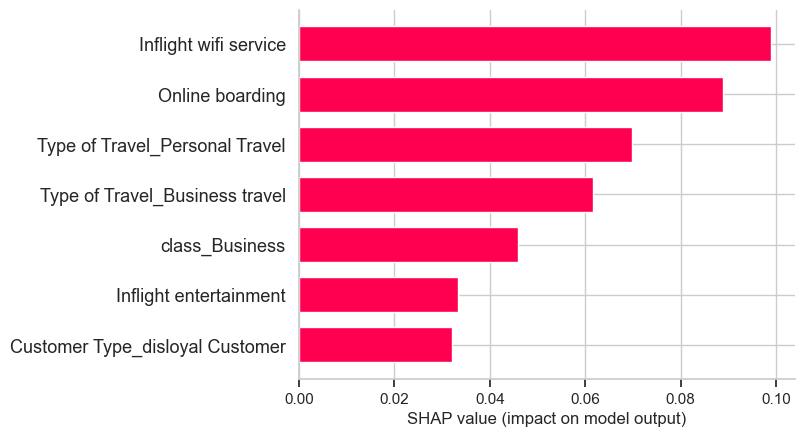

In [542]:
X_sample = X_train.sample(1000, random_state=42)

explainer = shap.TreeExplainer(rf, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_sample)

shap_values_class_1 = shap_values[:, :, 1]  

shap.bar_plot(np.mean(np.abs(shap_values_class_1), axis=0), feature_names=X_sample.columns)

SHAP показывает, насколько каждый признак влияет на предсказания модели. Наибольшее влияние оказывают `Inflight wifi service` и `Online boarding`, что говорит о высокой значимости удобства цифровых сервисов для клиентов. Также важны тип путешествия и класс обслуживания, подтверждая, что бизнес-клиенты и их условия перелета имеют существенное влияние на удовлетворенность. Нелояльность клиентов также влияет, но в меньшей степени.

### **Задание 16. (0.25 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [536]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_val.values,  
    feature_names=X_val.columns,
    class_names=['Class 0', 'Class 1'],
    mode="classification"
)

idx = np.random.randint(0, len(X_val))
sample = X_val.iloc[idx]

exp = explainer.explain_instance(sample.values, rf.predict_proba)

exp.show_in_notebook()

LIME показывает, что модель приняла решение в пользу класса 0 из-за типа путешествия, класса полета, качества WI-FI во время полета и онлайн регистации.

## Котобонус!

0.25 балла

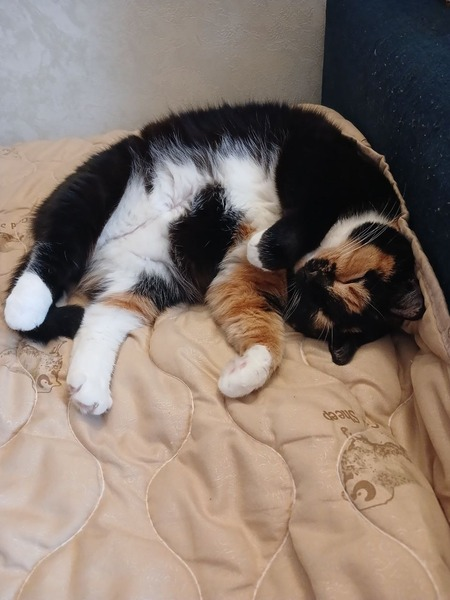

Мне кажется это кот Елены

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?